In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
data = pd.read_csv('data.txt', delim_whitespace=True)

In [12]:
def separate_by_name(data):
    #subsetting the dataframe by micrograph name
    i = 0
    micrographs = []
    df1 = None
    name = data.loc[0]["MicrographName"]
    oldIndex = 0
    newIndex = 0
    while (i < data.shape[0]):
        if (data.loc[i]["MicrographName"] != name):
            micrographs.append(data.iloc[oldIndex:i,:])
            oldIndex = i
            name = data.loc[i]["MicrographName"]
        i = i+1
    return micrographs

In [14]:
newlist = separate_by_name(data)

In [15]:
def scatter(micrograph):
   #select micrograph 1 as example, plotting it using matplotlib
    for (x,y) in list(zip(micrograph.X0, micrograph.Y0)):
        plt.scatter(x,y) 

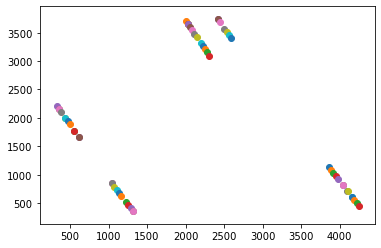

In [16]:
scatter(newlist[0])

In [17]:
def psi_extrapolate(x,y, psi, inter_dist, direction):
    dx = math.cos(psi)*inter_dist
    dy = math.sin(psi)*inter_dist
    if (direction):
        #positive direction
        new_point = (x+dx, y+dy)
    else:
        new_point = (x-dx, y-dy)
    return new_point

def L2_dist(x,y, x1, y1):
    return math.sqrt(math.pow((x-x1),2)+math.pow((y-y1),2))

In [92]:
def point_search(helix, point,xmin,xmax,ymin,ymax, dist, direction):
        helix = np.copy(helix)
        final_points = []
        rand_point = point
        while (True):
            theoretical_next = psi_extrapolate(rand_point[0],rand_point[1], -1*math.radians(rand_point[8]), 82.5, direction)
            #check the nearest points in data_matrix to these two points, if none are there, plot a temporary point and include it in the final points
            if (theoretical_next[0] > max_x or theoretical_next[1] > max_y or theoretical_next[0] < min_x or theoretical_next[1] < min_y):
                break
            i = 0
            point_found = False
            for point1, point2 in zip(helix[:,0], helix[:,1]):
                if L2_dist(theoretical_next[0],theoretical_next[1], point1, point2) < 15:
                    final_points.append((point1, point2))
                    rand_point = helix[i]
                    helix = np.delete(helix, i, 0)
                    point_found = True
                    break   
                i = i +1
            if (point_found == False):
                    final_points.append(theoretical_next)
                    rand_point[0] = theoretical_next[0]
                    rand_point[1] = theoretical_next[1]
        return final_points

In [93]:
import threading
import os
import concurrent.futures

#fitting algorithm

#convert micrograph to matrix
data_matrix = newlist[0].to_numpy()
import random

#separate matrix by helical ID
helices = np.split(data_matrix, np.where(np.diff(data_matrix[:,2]))[0]+1)

fitted_points = []

#loop through each helix

for helix in helices:
    fitted_points_in_helix = []
    rand_point = helix[random.randrange(0, helix.shape[0])]
    
    max_x = np.amax(helix,axis=0)[0]
    max_y = np.amax(helix,axis=0)[1]
    
    min_x = np.amin(helix,axis=0)[0]
    min_y = np.amin(helix,axis=0)[1]
    
    #two thread process to compute positive extrapolation and negative extrapolation at the same time
    with concurrent.futures.ThreadPoolExecutor() as executor:
        parameters = [(helix, rand_point ,min_x, max_x, min_y, max_y, 82.5, True), (helix, rand_point ,min_x, max_x, min_y, max_y, 82.5, False)]
        futures = [executor.submit(point_search, param[0], param[1], param[2], param[3], param[4], param[5], param[6], param[7]) for param in parameters]
        return_values = [future.result() for future in futures]
        fitted_points_in_helix = [item for sublist in return_values for item in sublist]
    for x in fitted_points_in_helix:
        fitted_points.append(x)

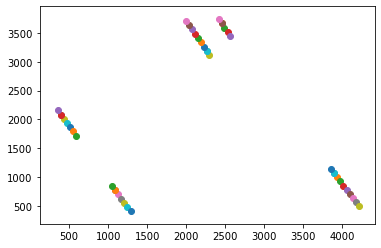

In [94]:
#select micrograph 1 as example, plotting it using matplotlib
for (x,y) in fitted_points:
    plt.scatter(x,y)


(array([13, 20, 33, 45], dtype=int64),)

hello world!
foo
